# Steam Game Clustering Model

Pipeline: Data → Feature Engineering (Tags specifici, no generi) → TF-IDF² → SVD → K-Means

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


## 1. Dati e Feature Engineering

In [2]:
df = pd.read_csv('datasets/steam-games-cleaned.csv')
print(f"Dataset: {len(df):,} giochi")

# ESCLUDI: tag generici + tag che sono generi
EXCLUDED_TAGS = {
    # Meta/Steam
    'indie', 'early access', 'early_access', 'free to play', 'free_to_play',
    'singleplayer', 'multiplayer', 'co-op', 'steam achievements', 'steam cloud',
    # GENERI (troppo comuni)
    'action', 'adventure', 'casual', 'strategy', 'simulation', 'rpg',
    'racing', 'sports', 'massively multiplayer', 'mmo', 'mmorpg',
}

def create_features(row):
    tags = str(row['tags']).split(',')
    
    weighted = []
    for i, tag in enumerate(tags[:15]):
        tag = tag.strip().lower()
        if tag and tag != 'nan' and tag not in EXCLUDED_TAGS:
            reps = max(1, int(3 * (0.85 ** i)))
            weighted.extend([tag] * reps)
    
    return ' '.join(weighted)

df['features'] = df.apply(create_features, axis=1)
print(f"Tag esclusi: {len(EXCLUDED_TAGS)}")

Dataset: 42,410 giochi
Tag esclusi: 21


In [3]:
# Verifica top tag rimanenti
all_tags = df['features'].str.split().explode()
print('TOP 15 TAG (dopo esclusione generi):')
print(all_tags.value_counts().head(15))

TOP 15 TAG (dopo esclusione generi):
features
puzzle         8532
horror         7763
platformer     6817
shooter        5375
2d             5038
sim            4212
novel          4012
visual         3999
exploration    3694
action         3612
vr             3445
turn-based     3367
survival       3358
&              3181
arcade         3010
Name: count, dtype: int64


## 2. TF-IDF²

In [4]:
tfidf = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3,
    sublinear_tf=True,
    norm=None
)

tfidf_matrix = tfidf.fit_transform(df['features'])

# IDF²
idf_original = tfidf.idf_
tfidf_squared = tfidf_matrix.multiply(idf_original)
tfidf_squared = normalize(tfidf_squared, norm='l2')

print(f"TF-IDF²: {tfidf_squared.shape}")

TF-IDF²: (42410, 500)


## 3. SVD

In [5]:
N_COMPONENTS = 50

svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
normalizer = Normalizer(norm='l2')

reduced = svd.fit_transform(tfidf_squared)
normalized_matrix = normalizer.fit_transform(reduced)

print(f"SVD: {normalized_matrix.shape}")
print(f"Variance: {svd.explained_variance_ratio_.sum():.1%}")

SVD: (42410, 50)
Variance: 48.4%


## 4. K-Means

In [6]:
MIN_CLUSTER_SIZE = 450
k_range = range(20, 50, 5)
results = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(normalized_matrix)
    score = silhouette_score(normalized_matrix, labels)
    min_size = pd.Series(labels).value_counts().min()
    valid = min_size >= MIN_CLUSTER_SIZE
    results.append({'k': k, 'silhouette': score, 'min_size': min_size, 'valid': valid})
    print(f"K={k}: Silhouette={score:.4f}, Min={min_size:,} {'✓' if valid else '✗'}")

results_df = pd.DataFrame(results)
valid_df = results_df[results_df['valid']]
optimal_k = int(valid_df.loc[valid_df['silhouette'].idxmax(), 'k']) if len(valid_df) > 0 else 30
print(f"\nK ottimale: {optimal_k}")

K=20: Silhouette=0.2425, Min=708 ✓
K=25: Silhouette=0.2763, Min=592 ✓
K=30: Silhouette=0.3089, Min=480 ✓
K=35: Silhouette=0.3326, Min=485 ✓
K=40: Silhouette=0.3574, Min=456 ✓
K=45: Silhouette=0.3676, Min=378 ✗

K ottimale: 40


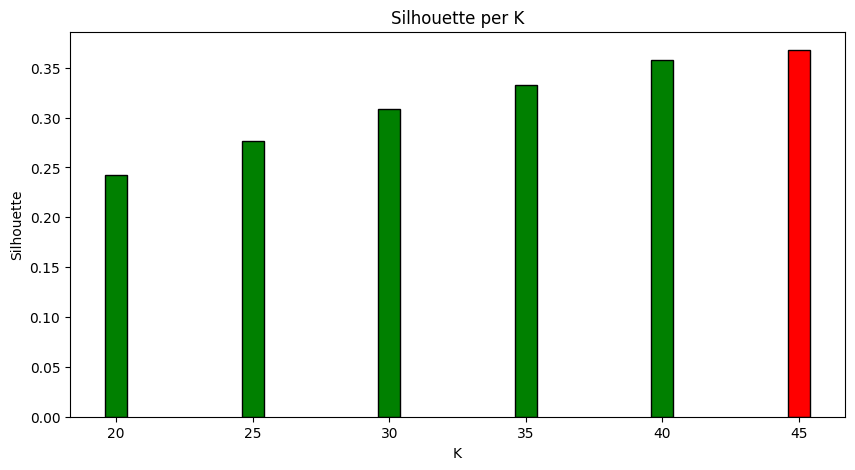

In [7]:
plt.figure(figsize=(10, 5))
colors = ['green' if r['valid'] else 'red' for r in results]
plt.bar(results_df['k'], results_df['silhouette'], color=colors, edgecolor='black')
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.title('Silhouette per K')
plt.xticks(results_df['k'])
plt.show()

In [8]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(normalized_matrix)

silhouette = silhouette_score(normalized_matrix, df['cluster'])
print(f"K={optimal_k}, Silhouette={silhouette:.4f}")

K=40, Silhouette=0.3574


## 5. Visualizzazione

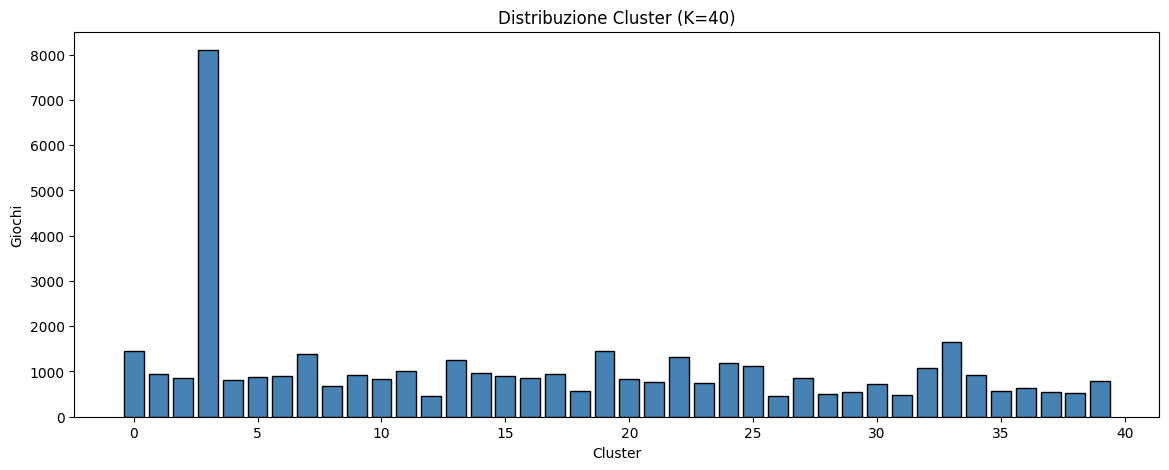

Min: 456, Max: 8,104


In [9]:
cluster_dist = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.bar(cluster_dist.index, cluster_dist.values, color='steelblue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Giochi')
plt.title(f'Distribuzione Cluster (K={optimal_k})')
plt.show()

print(f"Min: {cluster_dist.min():,}, Max: {cluster_dist.max():,}")

In [10]:
print("Calcolo t-SNE...")
SAMPLE = 5000
np.random.seed(42)
idx = np.random.choice(len(df), min(SAMPLE, len(df)), replace=False)

centroids = kmeans.cluster_centers_
combined = np.vstack([normalized_matrix[idx], centroids])

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
tsne_res = tsne.fit_transform(combined)

pts = tsne_res[:SAMPLE]
ctrs = tsne_res[SAMPLE:]

Calcolo t-SNE...


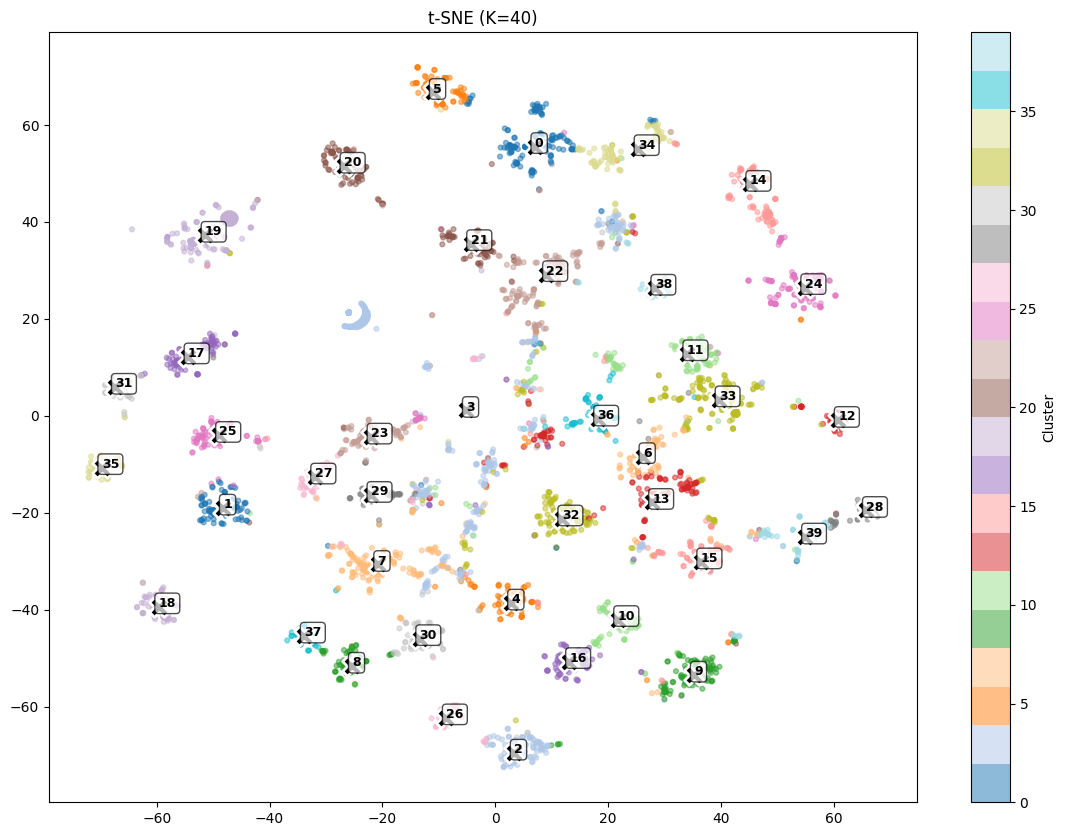

In [11]:
plt.figure(figsize=(14, 10))

scatter = plt.scatter(pts[:, 0], pts[:, 1], c=df['cluster'].iloc[idx], cmap='tab20', alpha=0.5, s=12)
plt.scatter(ctrs[:, 0], ctrs[:, 1], c='black', marker='X', s=200, edgecolor='white', linewidth=2)

for i, (x, y) in enumerate(ctrs):
    plt.annotate(str(i), (x, y), fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle='round', fc='white', alpha=0.7))

plt.colorbar(scatter, label='Cluster')
plt.title(f't-SNE (K={optimal_k})')
plt.show()

## 6. Salvataggio

In [13]:
model = {
    'dataframe': df,
    'matrix': normalized_matrix,
    'clustering_model': kmeans,
    'tfidf_vectoriozer': tfidf,
    'svd': svd,
    'normalizer': normalizer,
    'optimal_k': optimal_k,
    'silhouette_score': silhouette,
    'algorithm': f'TF-IDF² (no generi) + SVD({N_COMPONENTS}) + K-Means'
}

with open('models/steam_recommender.pkl', 'wb') as f:
    pickle.dump(model, f)

print(f"Salvato! K={optimal_k}, Silhouette={silhouette:.4f}")

Salvato! K=40, Silhouette=0.3574
